# 대구 교통사고 피해 예측 알고리즘 경진대회

- 대회 정보
    - target : ECLO(Equivalent Casualty Loss Only) 인명피해 심각도 (사고의 위험도)
        - ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1
    - 심사 기준 : RMSLE(Root Mean Squared Logarithmic Error)
        - Public 30%, Private 70%

    - 대회 목적 : 사고 원인 규명 및 예방

    - 대구 빅데이터활용센터와 한국자동차연구원 자동차데이터 포털에서 제공하는 외부 데이터 사용 가능

    - 심사 : 정확도 50% 데이터활용 10% 위험요인분석 10% 인사이트 10% 해결책 20%

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import torch
import os

SEED = 42

DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/DACON 경진대회/대구 교통사고 피해 예측/data/'

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


seed_everything(SEED)

In [4]:
country_acc = pd.read_csv(f'{DATA_PATH}countrywide_accident.csv') #
cctv = pd.read_csv(f'{DATA_PATH}대구 CCTV 정보.csv', encoding='cp949')
security_cam = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')
children_area = pd.read_csv(f'{DATA_PATH}대구 어린이 보호 구역 정보.csv', encoding='cp949')
parking = pd.read_csv(f'{DATA_PATH}대구 주차장 정보.csv', encoding='cp949')

train = pd.read_csv(f'{DATA_PATH}train.csv')
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
test_df = pd.read_csv(f'{DATA_PATH}test.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

<ipython-input-4-96e8b5933254>:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  security_cam = pd.read_csv(f'{DATA_PATH}대구 보안등 정보.csv', encoding='cp949')


In [5]:
country_acc.columns == train_df.columns

#대구일 필요가 없음? 지역정보 제외하고

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [6]:
country_acc
# 60만개의 정보

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,2019-01-01 00,화요일,맑음,서울특별시 강서구 방화동,교차로 - 교차로횡단보도내,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,40세,경상,0,0,1,0,3
1,COUNTRYWIDE_ACCIDENT_000001,2019-01-01 00,화요일,맑음,경기도 포천시 소흘읍,교차로 - 교차로안,건조,차대차,기타,직진우회전진행방해,...,상해없음,이륜,남,20세,경상,0,0,1,0,3
2,COUNTRYWIDE_ACCIDENT_000002,2019-01-01 00,화요일,맑음,경기도 양주시 고암동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,17세,중상,0,1,0,0,5
3,COUNTRYWIDE_ACCIDENT_000003,2019-01-01 00,화요일,맑음,경기도 남양주시 다산동,기타 - 기타,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,10세,중상,0,2,0,0,10
4,COUNTRYWIDE_ACCIDENT_000004,2019-01-01 00,화요일,맑음,인천광역시 부평구 부평동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,승용,남,56세,경상,0,0,2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,COUNTRYWIDE_ACCIDENT_602770,2021-12-31 23,금요일,흐림,부산광역시 해운대구 우동,교차로 - 교차로안,건조,차대차,기타,신호위반,...,상해없음,승합,남,52세,상해없음,0,1,1,0,8
602771,COUNTRYWIDE_ACCIDENT_602771,2021-12-31 23,금요일,맑음,서울특별시 성동구 행당동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,71세,경상,0,0,2,0,6
602772,COUNTRYWIDE_ACCIDENT_602772,2021-12-31 23,금요일,맑음,대전광역시 유성구 원신흥동,교차로 - 교차로안,건조,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,56세,경상,0,0,3,0,9
602773,COUNTRYWIDE_ACCIDENT_602773,2021-12-31 23,금요일,맑음,경기도 화성시 서신면,기타 - 기타,젖음/습기,차량단독,기타,안전운전불이행,...,부상신고,NaN,NaN,NaN,NaN,0,0,0,1,1


In [7]:
cctv

# 동별 cctv 개수 / 설치 연도? (사람들이 장기적인 시간을 두고 cctv에 영향 받음? )

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,대구광역시 북구 구암동 671-8,35.925294,128.552023,구암고교교차로(면허시험장삼거리→구암역),2,40,NaN,NaN,99.0,2021.0
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,대구광역시 북구 사수동 812,35.900977,128.513825,사수초교앞(삼영초교→사수중학교),2,30,NaN,NaN,2.0,2021.0
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,대구광역시 북구 대현동 270-8,35.882191,128.609791,신암초교 남측(공고R)(경대교→공고네거리),2,30,NaN,NaN,2.0,2021.0
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,대구광역시 북구 대현동 270-3,35.881737,128.611651,신암초교 남측(경대교)(공고네거리→경대교),2,30,NaN,NaN,2.0,2021.0


# 지역 관련 feature
- train : 총 199개의 시군구
- test : 총 192개의 시군구

{'대구광역시 동구 내동',
 '대구광역시 동구 둔산동',
 '대구광역시 동구 신무동',
 '대구광역시 북구 도남동',
 '대구광역시 중구 도원동',
 '대구광역시 중구 서야동',
 '대구광역시 중구 장관동'}

In [8]:
tmp = train_df['시군구'].value_counts().reset_index() # 총 199개의 시군구
tmp

# plt.plot(tmp.index, tmp.시군구)

,index,시군구
0,대구광역시 남구 대명동,1749
1,대구광역시 수성구 범어동,1173
2,대구광역시 달서구 상인동,1143
3,대구광역시 서구 비산동,968
4,대구광역시 서구 내당동,938
...,...,...
194,대구광역시 중구 도원동,2
195,대구광역시 동구 신용동,2
196,대구광역시 중구 동성로1가,2
197,대구광역시 북구 도남동,2


In [9]:
test_df['시군구'].value_counts().reset_index() #총 192개의 시군구 (7개만 제외)

,index,시군구
0,대구광역시 남구 대명동,422
1,대구광역시 수성구 범어동,351
2,대구광역시 달서구 상인동,315
3,대구광역시 수성구 만촌동,277
4,대구광역시 북구 산격동,264
...,...,...
187,대구광역시 북구 고성동1가,1
188,대구광역시 동구 능성동,1
189,대구광역시 중구 화전동,1
190,대구광역시 중구 서문로2가,1


In [10]:
train_region = set(train_df['시군구'].unique())
test_region = set(test_df['시군구'].unique())

train_region - test_region

{'대구광역시 동구 내동',
 '대구광역시 동구 둔산동',
 '대구광역시 동구 신무동',
 '대구광역시 북구 도남동',
 '대구광역시 중구 도원동',
 '대구광역시 중구 서야동',
 '대구광역시 중구 장관동'}

In [11]:
train_df.groupby(['시군구','도로형태'])[['ID']].count()

# 시군구별 도로형태별 ELOC
# 시군구별 도로형태별 날씨별  ELOC

train_df


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,28세,경상,0,0,1,0,3
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,52세,경상,0,0,1,0,3
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,중상,승용,남,73세,중상,0,2,0,0,10
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,여,57세,경상,0,0,1,0,3


In [12]:
test_df

# test에서 확인 가능한 정보 : 일시, 기상상태, 도로 형태, 노면 상태, 사고유형, 시군구
# 특정 시군구의 - 특정 도로형태는 볼 수 잇을 것 (겹칠 확률이? )

test_df.groupby(['시군구','도로형태'])[['ID']].count()

ID
시군구          도로형태              
대구광역시 남구 대명동 교차로 - 교차로부근     65
             교차로 - 교차로안      85
             교차로 - 교차로횡단보도내  22
             기타 - 기타         18
             단일로 - 고가도로위      4
...                          ..
대구광역시 중구 포정동 단일로 - 기타         4
대구광역시 중구 하서동 교차로 - 교차로부근      2
             단일로 - 기타         1
대구광역시 중구 향촌동 단일로 - 기타         5
대구광역시 중구 화전동 단일로 - 기타         1

[840 rows x 1 columns]

# 시간/날씨 관련 feature

In [13]:
train_df['사고일시'].value_counts().reset_index().rename(columns={'index': '사고일시', '사고일시': 'count'})


,사고일시,count
0,2019-11-15 18,13
1,2019-03-21 15,11
2,2020-01-06 18,11
3,2020-09-11 19,11
4,2019-12-20 18,10
...,...,...
18052,2020-12-15 17,1
18053,2020-12-15 16,1
18054,2019-10-29 20,1
18055,2020-12-15 10,1


In [14]:
train_df['기상상태'].value_counts() # 맑음 여부 추가

train_df.groupby(['기상상태'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].sum()

,사망자수,중상자수,경상자수,부상자수,ECLO
기상상태,,,,,
기타,1,22,50,7,277
눈,1,1,7,1,37
맑음,265,9383,38781,4609,170517
비,36,763,2788,322,12861
안개,0,1,13,0,44
흐림,5,222,746,86,3484


In [15]:
print(train_df['노면상태'].value_counts(), end = '\n') # 건조 여부 추가

train_df.groupby(['노면상태'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].mean()

건조       36420
젖음/습기     3100
기타          58
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64


,사망자수,중상자수,경상자수,부상자수,ECLO
노면상태,,,,,
건조,0.007359,0.259583,1.071472,0.126963,4.712878
기타,0.034483,0.344828,0.637931,0.103448,4.086207
서리/결빙,0.000000,0.240000,0.880000,0.320000,4.160000
적설,0.000000,0.000000,1.000000,0.000000,3.000000
젖음/습기,0.011935,0.294194,1.063871,0.124516,4.906452
침수,0.333333,0.000000,0.666667,0.333333,5.666667


In [16]:
print(train_df['사고유형'].value_counts()) # 차대 사람의 경우 부상정도 가장 심각함 - 차대 사람 여부추가

train_df.groupby(['사고유형'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].sum()

차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64


,사망자수,중상자수,경상자수,부상자수,ECLO
사고유형,,,,,
차대사람,125,2499,3888,677,26086
차대차,137,7560,37968,4090,157164
차량단독,46,333,529,258,3970


In [17]:
print(train_df['사고유형 - 세부분류'].value_counts()) # 사고 유형 - 결과

train_df.groupby(['사고유형 - 세부분류'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].mean()

# ECLO 범위에 따라서 상 - 중 - 하 범주화

측면충돌          17104
기타            10630
추돌             5885
횡단중            2443
정면충돌            837
차도통행중           616
후진중충돌           613
보도통행중           524
길가장자리구역통행중      467
공작물충돌           324
전도전복 - 전도       144
전도전복 - 전복        10
도로외이탈 - 추락        8
도로외이탈 - 기타        4
Name: 사고유형 - 세부분류, dtype: int64


,사망자수,중상자수,경상자수,부상자수,ECLO
사고유형 - 세부분류,,,,,
공작물충돌,0.083333,0.373457,0.540123,0.290123,4.611111
기타,0.007432,0.256256,0.909878,0.141392,4.226623
길가장자리구역통행중,0.000000,0.214133,0.642398,0.154176,3.152034
도로외이탈 - 기타,0.000000,0.000000,0.500000,0.500000,2.000000
도로외이탈 - 추락,0.375000,0.375000,0.375000,0.000000,6.750000
보도통행중,0.009542,0.366412,0.593511,0.078244,3.786260
전도전복 - 전도,0.034722,0.312500,0.388889,0.395833,3.472222
전도전복 - 전복,0.100000,0.700000,0.400000,0.200000,5.900000
정면충돌,0.020311,0.393070,1.084827,0.117085,5.540024


In [18]:

print(train_df['법규위반'].value_counts()) # 사고 유형 - 사고 원인

train_df.groupby(['법규위반'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].mean()

#과속 여부 /

안전운전불이행      21876
안전거리미확보       5277
신호위반          3786
교차로운행방법위반     2750
기타            1396
보행자보호의무위반     1154
직진우회전진행방해      980
차로위반           949
중앙선침범          881
불법유턴           427
과속             133
Name: 법규위반, dtype: int64


,사망자수,중상자수,경상자수,부상자수,ECLO
법규위반,,,,,
과속,0.165414,0.661654,1.052632,0.112782,8.233083
교차로운행방법위반,0.000364,0.249091,1.214182,0.128000,5.019636
기타,0.013610,0.314470,0.767908,0.118911,4.131089
보행자보호의무위반,0.006932,0.448007,0.558059,0.041594,4.025130
불법유턴,0.014052,0.248244,0.964871,0.121780,4.398126
신호위반,0.009773,0.417855,1.046751,0.099842,5.427100
안전거리미확보,0.001327,0.182490,1.340913,0.145537,5.093993
안전운전불이행,0.008731,0.240218,1.021850,0.130051,4.484001
중앙선침범,0.017026,0.392736,1.095346,0.132804,5.552781


In [19]:
print(train_df['가해운전자 차종'].value_counts() )#고위험 차종 - 중위험 차종 - 저위험 차종 등 범주화 *** 차종에 따라 상해정도 달라질 것

train_df.groupby(['가해운전자 차종'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].mean()

# 크기별 범주화 -

승용             26705
이륜              4091
화물              4040
승합              1376
자전거             1234
기타불명             978
원동기              462
건설기계             425
개인형이동수단(PM)      172
특수               113
사륜오토바이(ATV)       10
농기계                3
Name: 가해운전자 차종, dtype: int64


,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 차종,,,,,
개인형이동수단(PM),0.000000,0.296512,0.534884,0.267442,3.354651
건설기계,0.014118,0.315294,1.171765,0.049412,5.282353
기타불명,0.000000,0.116564,0.592025,0.375256,2.734151
농기계,0.000000,0.000000,1.000000,0.333333,3.333333
사륜오토바이(ATV),0.000000,0.300000,0.300000,0.500000,2.900000
승용,0.006179,0.254260,1.160756,0.096798,4.912151
승합,0.010901,0.336483,0.992733,0.120640,4.890262
원동기,0.008658,0.298701,0.720779,0.261905,4.004329
이륜,0.011489,0.276705,0.838915,0.249083,4.264239


In [20]:
train_df.groupby(['가해운전자 차종'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].sum()

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 차종,,,,,
개인형이동수단(PM),0,51,92,46,577
건설기계,6,134,498,21,2245
기타불명,0,114,579,367,2674
농기계,0,0,3,1,10
사륜오토바이(ATV),0,3,3,5,29
승용,165,6790,30998,2585,131179
승합,15,463,1366,166,6729
원동기,4,138,333,121,1850
이륜,47,1132,3432,1019,17445


In [21]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,28세,경상,0,0,1,0,3
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,52세,경상,0,0,1,0,3
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,중상,승용,남,73세,중상,0,2,0,0,10
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,여,57세,경상,0,0,1,0,3


In [22]:
train_df['ECLO'].value_counts()

3     18675
5      6743
6      4967
1      2578
9      1528
8      1152
4       818
10      611
12      611
11      394
15      283
7       263
13      194
2       150
14      145
16      101
18       89
17       78
20       39
19       36
21       33
24       18
23       17
22       17
26       12
27       11
25        7
28        6
30        5
31        4
34        3
32        3
37        3
33        2
35        2
36        1
40        1
65        1
56        1
47        1
57        1
45        1
52        1
74        1
39        1
66        1
Name: ECLO, dtype: int64

In [23]:
train_df['가해운전자 성별'].value_counts()
train_df.groupby(['가해운전자 성별'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].mean()

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 성별,,,,,
기타불명,0.000000,0.114604,0.597363,0.373225,2.738337
남,0.009053,0.272339,1.065503,0.124432,4.773165
여,0.004702,0.247310,1.132693,0.108871,4.790513


In [24]:
# 10살 단위로 범주화 가능
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].astype(str).str.replace('[^0-9]', '', regex=True)
train_df['가해운전자 연령'] = train_df['가해운전자 연령'].replace('',-1)
train_df['가해운전자 연령'].value_counts()

train_df['가해운전자 연령대'] = train_df['가해운전자 연령'].astype(int)//10

train_df.groupby(['가해운전자 연령대'])[['사망자수', '중상자수','경상자수', '부상자수', 'ECLO']].sum()

# sum, mean 함께 확인 필요

,사망자수,중상자수,경상자수,부상자수,ECLO
가해운전자 연령대,,,,,
-1,0,116,593,370,2729
0,0,4,15,11,76
1,11,314,1200,285,5565
2,45,1477,6070,769,26814
3,44,1510,6174,683,27195
4,42,1818,7358,740,32324
5,59,2459,9726,949,43012
6,70,1923,8123,769,35453
7,29,641,2726,382,12055


In [25]:
train_df['가해운전자 연령']

0        51
1        39
2        70
3        49
4        30
         ..
39604    52
39605    60
39606    60
39607    40
39608    27
Name: 가해운전자 연령, Length: 39609, dtype: object

In [26]:
train_df['가해운전자 상해정도'].value_counts()


상해없음    29309
경상       4088
기타불명     2491
부상신고     2458
중상       1171
사망         92
Name: 가해운전자 상해정도, dtype: int64

In [27]:
train_df['피해운전자 차종'].value_counts()

승용             20315
보행자             6833
이륜              5209
자전거             2145
화물              2047
승합              1015
원동기              581
개인형이동수단(PM)      164
건설기계             120
기타불명              86
특수                73
사륜오토바이(ATV)       22
농기계                8
Name: 피해운전자 차종, dtype: int64

In [28]:
 # 연령에 따라 상해정도도 다를 것 *** + 연령 범주화 할 것
train_df['피해운전자 연령'] = train_df['피해운전자 연령'].astype(str).str.replace('[^0-9]', '', regex=True)
train_df['피해운전자 연령'] = train_df['피해운전자 연령'].replace('',-1)
train_df['피해운전자 연령'].value_counts()

-1    1060
59     867
57     844
26     816
50     815
      ... 
91       4
93       2
94       2
92       1
98       1
Name: 피해운전자 연령, Length: 96, dtype: int64

In [29]:
train_df['피해운전자 상해정도'].value_counts()

경상      25034
중상       7287
상해없음     4281
부상신고     1516
기타불명      326
사망        174
Name: 피해운전자 상해정도, dtype: int64

In [30]:
train_df['사망자수'].value_counts() # 어떤 사고 유형에서 가해자 상해정도에 따른 -> 사망자 / 피해자 상해정도에 따른 -> 사망자가 높은지 등

0    39309
1      292
2        8
Name: 사망자수, dtype: int64

In [31]:
train_df['중상자수'].value_counts()

0    30136
1     8724
2      618
3       98
4       28
5        4
6        1
Name: 중상자수, dtype: int64

In [32]:
train_df['경상자수'].value_counts()

1     20913
0     10284
2      5560
3      1728
4       732
5       259
6        77
7        32
8         7
9         7
10        2
15        2
14        1
11        1
12        1
18        1
13        1
22        1
Name: 경상자수, dtype: int64

In [33]:
train_df['부상자수'].value_counts()

0     35168
1      4046
2       279
3        67
4        35
5         9
6         3
7         1
10        1
Name: 부상자수, dtype: int64

In [34]:
train_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', '가해운전자 연령대'],
      dtype='object')

# 세부 피쳐 추가

In [35]:
train_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', '가해운전자 연령대'],
      dtype='object')

In [36]:
train_df = train_df.fillna(0)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     39609 non-null  object
 15  피해운전자 성별     39609 non-null  object
 16  피해운전자 연령     39609 non-null  object
 17  피해운전자 상해정도   39609 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [37]:
train_df = train_df.fillna(0)

train_df['ID'] = train_df['ID'].str[-5:]

train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
train_df['년도'] = train_df['사고일시'].dt.year
train_df['월'] = train_df['사고일시'].dt.month
train_df['요일'] = train_df['사고일시'].dt.dayofweek
train_df['시간'] = train_df['사고일시'].dt.time

train_df['시'] = train_df['시군구'].str.split(' ').str[0]
train_df['동'] = train_df['시군구'].str.split(' ').str[1]

train_df['피해운전자 연령대'] = train_df['피해운전자 연령'].astype(int)//10
train_df['가해운전자 연령대'] = train_df['가해운전자 연령'].astype(int)//10

train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,시간,시,동,피해운전자 연령대
0,00000,2019-01-01 00:00:00,1,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,0,0,5,5,2019,1,00:00:00,대구광역시,중구,7
1,00001,2019-01-01 00:00:00,1,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,1,0,3,3,2019,1,00:00:00,대구광역시,달서구,6
2,00002,2019-01-01 01:00:00,1,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,1,0,3,7,2019,1,01:00:00,대구광역시,수성구,3
3,00003,2019-01-01 02:00:00,1,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,0,0,5,4,2019,1,02:00:00,대구광역시,북구,3
4,00004,2019-01-01 04:00:00,1,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,3,2019,1,04:00:00,대구광역시,동구,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,39604,2021-12-31 19:00:00,4,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,1,0,3,5,2021,12,19:00:00,대구광역시,수성구,2
39605,39605,2021-12-31 19:00:00,4,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,1,0,3,6,2021,12,19:00:00,대구광역시,달서구,5
39606,39606,2021-12-31 21:00:00,4,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,0,0,10,6,2021,12,21:00:00,대구광역시,달서구,7
39607,39607,2021-12-31 22:00:00,4,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,4,2021,12,22:00:00,대구광역시,달서구,5


# 상관관계 파악

In [38]:
train_df_corr = train_df.copy()

train_df_corr = train_df_corr.astype(str)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for cols in train_df_corr.columns :
    train_df_corr[cols] = encoder.fit_transform(train_df_corr[cols])

train_df_corr

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,시간,시,동,피해운전자 연령대
0,0,0,1,2,155,6,0,0,2,7,...,0,0,35,6,0,0,0,0,7,8
1,1,0,1,5,4,6,0,0,5,2,...,1,0,21,4,0,0,0,0,1,7
2,2,1,1,2,124,6,0,0,9,7,...,1,0,21,8,0,0,1,0,6,4
3,3,2,1,2,98,6,0,1,10,7,...,0,0,35,5,0,0,2,0,4,4
4,4,3,1,2,65,6,0,1,10,7,...,1,0,21,4,0,0,4,0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,39604,18053,4,2,135,1,0,1,11,5,...,1,0,21,6,2,3,19,0,6,3
39605,39605,18053,4,2,11,6,0,1,11,6,...,1,0,21,7,2,3,19,0,1,6
39606,39606,18054,4,2,16,1,0,1,11,1,...,0,0,1,7,2,3,21,0,1,8
39607,39607,18055,4,2,21,3,0,1,10,7,...,1,0,21,5,2,3,22,0,1,6


In [39]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,시간,시,동,피해운전자 연령대
0,00000,2019-01-01 00:00:00,1,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,0,0,5,5,2019,1,00:00:00,대구광역시,중구,7
1,00001,2019-01-01 00:00:00,1,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,1,0,3,3,2019,1,00:00:00,대구광역시,달서구,6
2,00002,2019-01-01 01:00:00,1,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,1,0,3,7,2019,1,01:00:00,대구광역시,수성구,3
3,00003,2019-01-01 02:00:00,1,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,0,0,5,4,2019,1,02:00:00,대구광역시,북구,3
4,00004,2019-01-01 04:00:00,1,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,3,2019,1,04:00:00,대구광역시,동구,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,39604,2021-12-31 19:00:00,4,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,1,0,3,5,2021,12,19:00:00,대구광역시,수성구,2
39605,39605,2021-12-31 19:00:00,4,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,1,0,3,6,2021,12,19:00:00,대구광역시,달서구,5
39606,39606,2021-12-31 21:00:00,4,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,0,0,10,6,2021,12,21:00:00,대구광역시,달서구,7
39607,39607,2021-12-31 22:00:00,4,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,4,2021,12,22:00:00,대구광역시,달서구,5


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/uti

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  func(*args, *

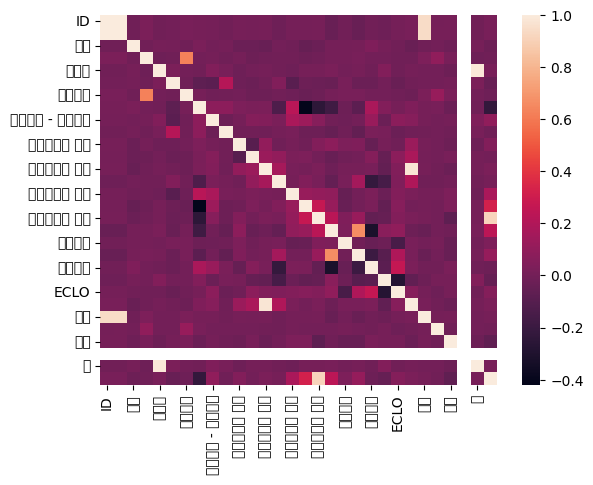

In [40]:
k = abs(train_df_corr.corr()['ECLO']).sort_values(ascending=False)

sns.heatmap(train_df_corr.corr())

In [75]:
train_df_corr.corr()['법규위반'].sort_values()

중상자수          -0.056361
피해운전자 상해정도    -0.043763
ECLO          -0.029623
사고유형 - 세부분류   -0.023955
피해운전자 성별      -0.022796
피해운전자 연령      -0.021269
시간            -0.012467
기상상태          -0.010530
사망자수          -0.010372
가해운전자 연령대     -0.009665
피해운전자 연령대     -0.009432
가해운전자 연령      -0.009363
가해운전자 차종      -0.008516
가해운전자 성별      -0.006970
년도            -0.004991
노면상태          -0.004514
사고일시          -0.004154
ID            -0.004063
월              0.000578
가해운전자 상해정도     0.003334
요일             0.004995
피해운전자 차종       0.013153
시군구            0.017783
부상자수           0.017875
동              0.018342
경상자수           0.019975
사고유형           0.083042
도로형태           0.212754
법규위반           1.000000
시                   NaN
Name: 법규위반, dtype: float64

In [56]:
train_df_corr.corr()['ECLO'].sort_values()

부상자수          -0.275296
사망자수          -0.149622
도로형태          -0.035003
법규위반          -0.029623
월             -0.015739
노면상태          -0.013100
가해운전자 차종      -0.011237
기상상태          -0.010214
시군구           -0.010199
동             -0.008204
요일            -0.007963
ID             0.002714
사고일시           0.002769
년도             0.003781
사고유형           0.007507
시간             0.009112
가해운전자 상해정도     0.036326
가해운전자 연령       0.044467
피해운전자 연령       0.046672
피해운전자 차종       0.048963
피해운전자 연령대      0.057257
피해운전자 성별       0.058226
가해운전자 연령대      0.059711
가해운전자 성별       0.077181
사고유형 - 세부분류    0.077730
피해운전자 상해정도     0.096168
중상자수           0.190531
경상자수           0.266547
ECLO           1.000000
시                   NaN
Name: ECLO, dtype: float64

In [58]:
train_df_corr.corr()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,시간,시,동,피해운전자 연령대
ID,1.000000,0.999865,-0.011561,0.026528,-0.004441,-0.001725,0.017684,0.009611,0.006364,-0.004063,...,-0.005576,-0.018200,0.002714,0.014871,0.941466,0.007122,0.010641,NaN,-0.004662,0.014192
사고일시,0.999865,1.000000,-0.011436,0.026720,-0.004269,-0.001787,0.017822,0.009321,0.006982,-0.004154,...,-0.005741,-0.018398,0.002769,0.015043,0.942236,0.011286,0.010570,NaN,-0.004530,0.014332
요일,-0.011561,-0.011436,1.000000,-0.003655,0.011072,0.002372,-0.010680,0.019268,-0.003076,0.004995,...,0.038971,0.008402,-0.007963,-0.036641,-0.011953,-0.002095,-0.016051,NaN,0.011407,-0.022462
기상상태,0.026528,0.026720,-0.003655,1.000000,-0.017900,-0.011271,0.625393,0.000596,0.006221,-0.010530,...,-0.000924,-0.002960,-0.010214,-0.011826,0.033193,0.093623,0.015927,NaN,-0.019706,-0.009869
시군구,-0.004441,-0.004269,0.011072,-0.017900,1.000000,0.025542,-0.000768,-0.007216,0.044912,0.017783,...,-0.011555,0.051053,-0.010199,0.003997,-0.002048,-0.002020,-0.025016,NaN,0.983541,0.018030
도로형태,-0.001725,-0.001787,0.002372,-0.011271,0.025542,1.000000,-0.012289,-0.075271,-0.081859,0.212754,...,-0.030787,-0.000399,-0.035003,-0.007159,-0.002827,0.001921,0.002900,NaN,0.024279,-0.039790
노면상태,0.017684,0.017822,-0.010680,0.625393,-0.000768,-0.012289,1.000000,0.011265,-0.010013,-0.004514,...,-0.000370,-0.000973,-0.013100,-0.022330,0.026779,0.117532,0.023081,NaN,-0.002773,-0.016917
사고유형,0.009611,0.009321,0.019268,0.000596,-0.007216,-0.075271,0.011265,1.000000,0.083999,0.083042,...,0.178806,0.048277,0.007507,0.040376,0.008726,0.018464,-0.027992,NaN,-0.004898,-0.229627
사고유형 - 세부분류,0.006364,0.006982,-0.003076,0.006221,0.044912,-0.081859,-0.010013,0.083999,1.000000,-0.023955,...,0.121409,-0.026066,0.077730,0.059871,0.008784,0.001024,0.004155,NaN,0.038317,0.092452
법규위반,-0.004063,-0.004154,0.004995,-0.010530,0.017783,0.212754,-0.004514,0.083042,-0.023955,1.000000,...,0.019975,0.017875,-0.029623,-0.009665,-0.004991,0.000578,-0.012467,NaN,0.018342,-0.009432


In [57]:
abs(train_df_corr.corr()['ECLO']).sort_values(ascending=False)

ECLO           1.000000
부상자수           0.275296
경상자수           0.266547
중상자수           0.190531
사망자수           0.149622
피해운전자 상해정도     0.096168
사고유형 - 세부분류    0.077730
가해운전자 성별       0.077181
가해운전자 연령대      0.059711
피해운전자 성별       0.058226
피해운전자 연령대      0.057257
피해운전자 차종       0.048963
피해운전자 연령       0.046672
가해운전자 연령       0.044467
가해운전자 상해정도     0.036326
도로형태           0.035003
법규위반           0.029623
월              0.015739
노면상태           0.013100
가해운전자 차종       0.011237
기상상태           0.010214
시군구            0.010199
시간             0.009112
동              0.008204
요일             0.007963
사고유형           0.007507
년도             0.003781
사고일시           0.002769
ID             0.002714
시                   NaN
Name: ECLO, dtype: float64

In [68]:
abs(train_df_corr.corr()['가해운전자 연령대']).sort_values(ascending=False)

가해운전자 연령대      1.000000
가해운전자 연령       0.974160
가해운전자 상해정도     0.192608
가해운전자 성별       0.175818
가해운전자 차종       0.125652
부상자수           0.064574
사고유형 - 세부분류    0.059871
ECLO           0.059711
사고유형           0.040376
요일             0.036641
시간             0.031151
피해운전자 연령대      0.024990
경상자수           0.024910
피해운전자 연령       0.023485
노면상태           0.022330
피해운전자 상해정도     0.021120
피해운전자 차종       0.021081
중상자수           0.017660
사고일시           0.015043
ID             0.014871
년도             0.014057
사망자수           0.013604
기상상태           0.011826
법규위반           0.009665
도로형태           0.007159
월              0.005973
동              0.004154
시군구            0.003997
피해운전자 성별       0.000752
시                   NaN
Name: 가해운전자 연령대, dtype: float64

In [74]:
abs(train_df_corr.corr()['가해운전자 성별']).sort_values(ascending=False)

가해운전자 성별       1.000000
가해운전자 연령대      0.175818
가해운전자 연령       0.127819
가해운전자 상해정도     0.100969
가해운전자 차종       0.093532
ECLO           0.077181
사고유형 - 세부분류    0.056608
경상자수           0.052187
부상자수           0.047283
피해운전자 상해정도     0.041262
피해운전자 성별       0.034014
요일             0.030882
피해운전자 차종       0.027603
도로형태           0.026005
기상상태           0.025458
노면상태           0.024839
사고유형           0.020205
시간             0.015046
사망자수           0.013010
법규위반           0.006970
사고일시           0.005780
ID             0.005709
년도             0.005125
동              0.003926
피해운전자 연령       0.001914
월              0.001085
시군구            0.000459
중상자수           0.000172
피해운전자 연령대      0.000145
시                   NaN
Name: 가해운전자 성별, dtype: float64

In [65]:
abs(train_df_corr.corr()['기상상태']).sort_values(ascending=False)

기상상태           1.000000
노면상태           0.625393
월              0.093623
년도             0.033193
사고일시           0.026720
ID             0.026528
가해운전자 성별       0.025458
피해운전자 성별       0.023720
동              0.019706
시군구            0.017900
중상자수           0.015987
시간             0.015927
가해운전자 연령       0.013674
피해운전자 연령       0.013667
가해운전자 연령대      0.011826
도로형태           0.011271
법규위반           0.010530
ECLO           0.010214
피해운전자 연령대      0.009869
사망자수           0.006727
피해운전자 상해정도     0.006580
사고유형 - 세부분류    0.006221
피해운전자 차종       0.005972
가해운전자 상해정도     0.004911
가해운전자 차종       0.003692
요일             0.003655
부상자수           0.002960
경상자수           0.000924
사고유형           0.000596
시                   NaN
Name: 기상상태, dtype: float64

In [66]:
abs(train_df_corr.corr()['노면상태']).sort_values(ascending=False)

노면상태           1.000000
기상상태           0.625393
월              0.117532
피해운전자 성별       0.034464
년도             0.026779
가해운전자 성별       0.024839
가해운전자 연령       0.024571
시간             0.023081
가해운전자 연령대      0.022330
피해운전자 연령       0.022182
피해운전자 차종       0.018819
중상자수           0.018359
사고일시           0.017822
ID             0.017684
피해운전자 연령대      0.016917
사망자수           0.014980
ECLO           0.013100
도로형태           0.012289
사고유형           0.011265
요일             0.010680
사고유형 - 세부분류    0.010013
법규위반           0.004514
가해운전자 상해정도     0.004317
동              0.002773
피해운전자 상해정도     0.002374
가해운전자 차종       0.002209
부상자수           0.000973
시군구            0.000768
경상자수           0.000370
시                   NaN
Name: 노면상태, dtype: float64

In [67]:
abs(train_df_corr.corr()['도로형태']).sort_values(ascending=False)

도로형태           1.000000
법규위반           0.212754
피해운전자 차종       0.090744
사고유형 - 세부분류    0.081859
사고유형           0.075271
가해운전자 상해정도     0.045500
피해운전자 연령대      0.039790
ECLO           0.035003
피해운전자 상해정도     0.032756
경상자수           0.030787
피해운전자 연령       0.029515
중상자수           0.028492
가해운전자 성별       0.026005
시군구            0.025542
동              0.024279
피해운전자 성별       0.024147
가해운전자 차종       0.018257
사망자수           0.015184
노면상태           0.012289
기상상태           0.011271
가해운전자 연령대      0.007159
가해운전자 연령       0.005281
시간             0.002900
년도             0.002827
요일             0.002372
월              0.001921
사고일시           0.001787
ID             0.001725
부상자수           0.000399
시                   NaN
Name: 도로형태, dtype: float64

In [59]:
abs(train_df_corr.corr()['피해운전자 상해정도']).sort_values(ascending=False)

피해운전자 상해정도     1.000000
중상자수           0.665956
경상자수           0.317416
피해운전자 연령대      0.237444
피해운전자 연령       0.230211
사고유형           0.184159
피해운전자 성별       0.114680
ECLO           0.096168
피해운전자 차종       0.095271
가해운전자 차종       0.081660
부상자수           0.073152
가해운전자 상해정도     0.052133
법규위반           0.043763
가해운전자 성별       0.041262
ID             0.040468
사고일시           0.040438
년도             0.039216
사망자수           0.034259
도로형태           0.032756
가해운전자 연령대      0.021120
시군구            0.021085
가해운전자 연령       0.019236
동              0.017893
시간             0.014148
사고유형 - 세부분류    0.008660
기상상태           0.006580
월              0.003453
요일             0.002494
노면상태           0.002374
시                   NaN
Name: 피해운전자 상해정도, dtype: float64

In [60]:
abs(train_df_corr.corr()['사고유형 - 세부분류']).sort_values(ascending=False)

사고유형 - 세부분류    1.000000
피해운전자 차종       0.174972
피해운전자 성별       0.133105
경상자수           0.121409
피해운전자 연령대      0.092452
사고유형           0.083999
도로형태           0.081859
ECLO           0.077730
피해운전자 연령       0.061595
가해운전자 연령대      0.059871
가해운전자 성별       0.056608
가해운전자 연령       0.049711
시군구            0.044912
동              0.038317
부상자수           0.026066
법규위반           0.023955
가해운전자 상해정도     0.022730
사망자수           0.015917
노면상태           0.010013
년도             0.008784
피해운전자 상해정도     0.008660
사고일시           0.006982
ID             0.006364
기상상태           0.006221
가해운전자 차종       0.005423
시간             0.004155
요일             0.003076
중상자수           0.001383
월              0.001024
시                   NaN
Name: 사고유형 - 세부분류, dtype: float64

In [62]:
abs(train_df_corr.corr()['가해운전자 성별']).sort_values(ascending=False)

가해운전자 성별       1.000000
가해운전자 연령대      0.175818
가해운전자 연령       0.127819
가해운전자 상해정도     0.100969
가해운전자 차종       0.093532
ECLO           0.077181
사고유형 - 세부분류    0.056608
경상자수           0.052187
부상자수           0.047283
피해운전자 상해정도     0.041262
피해운전자 성별       0.034014
요일             0.030882
피해운전자 차종       0.027603
도로형태           0.026005
기상상태           0.025458
노면상태           0.024839
사고유형           0.020205
시간             0.015046
사망자수           0.013010
법규위반           0.006970
사고일시           0.005780
ID             0.005709
년도             0.005125
동              0.003926
피해운전자 연령       0.001914
월              0.001085
시군구            0.000459
중상자수           0.000172
피해운전자 연령대      0.000145
시                   NaN
Name: 가해운전자 성별, dtype: float64

In [63]:
abs(train_df_corr.corr()['가해운전자 연령대']).sort_values(ascending=False)

가해운전자 연령대      1.000000
가해운전자 연령       0.974160
가해운전자 상해정도     0.192608
가해운전자 성별       0.175818
가해운전자 차종       0.125652
부상자수           0.064574
사고유형 - 세부분류    0.059871
ECLO           0.059711
사고유형           0.040376
요일             0.036641
시간             0.031151
피해운전자 연령대      0.024990
경상자수           0.024910
피해운전자 연령       0.023485
노면상태           0.022330
피해운전자 상해정도     0.021120
피해운전자 차종       0.021081
중상자수           0.017660
사고일시           0.015043
ID             0.014871
년도             0.014057
사망자수           0.013604
기상상태           0.011826
법규위반           0.009665
도로형태           0.007159
월              0.005973
동              0.004154
시군구            0.003997
피해운전자 성별       0.000752
시                   NaN
Name: 가해운전자 연령대, dtype: float64

In [64]:
abs(train_df_corr.corr()['가해운전자 차종']).sort_values(ascending=False)

가해운전자 차종       1.000000
가해운전자 연령대      0.125652
가해운전자 연령       0.101697
가해운전자 성별       0.093532
피해운전자 상해정도     0.081660
피해운전자 연령       0.047562
피해운전자 연령대      0.046338
경상자수           0.043695
중상자수           0.035729
사고유형           0.033774
사망자수           0.031123
요일             0.029059
시간             0.021684
도로형태           0.018257
동              0.018029
시군구            0.015836
가해운전자 상해정도     0.013460
피해운전자 성별       0.011438
ECLO           0.011237
년도             0.009963
ID             0.008761
사고일시           0.008687
법규위반           0.008516
부상자수           0.008207
피해운전자 차종       0.008197
사고유형 - 세부분류    0.005423
기상상태           0.003692
노면상태           0.002209
월              0.001297
시                   NaN
Name: 가해운전자 차종, dtype: float64

In [42]:
train_df_corr.corr()['사망자수'].sort_values()

ECLO          -0.149622
피해운전자 차종      -0.045230
피해운전자 성별      -0.040051
경상자수          -0.038434
시간            -0.037692
사고유형          -0.022436
부상자수          -0.020852
사고유형 - 세부분류   -0.015917
가해운전자 성별      -0.013010
법규위반          -0.010372
중상자수          -0.004368
ID            -0.003635
사고일시          -0.003608
년도            -0.003189
시군구           -0.002488
동              0.000544
요일             0.003101
기상상태           0.006727
월              0.009452
가해운전자 연령       0.012734
가해운전자 연령대      0.013604
노면상태           0.014980
도로형태           0.015184
가해운전자 상해정도     0.016226
피해운전자 연령대      0.030671
가해운전자 차종       0.031123
피해운전자 상해정도     0.034259
피해운전자 연령       0.037868
사망자수           1.000000
시                   NaN
Name: 사망자수, dtype: float64

In [43]:
train_df_corr.corr()['부상자수'].sort_values()

ECLO          -0.275296
가해운전자 상해정도    -0.157451
중상자수          -0.095965
경상자수          -0.085249
가해운전자 연령대     -0.064574
피해운전자 성별      -0.057931
가해운전자 연령      -0.054442
가해운전자 성별      -0.047283
피해운전자 연령      -0.046260
피해운전자 연령대     -0.044899
피해운전자 차종      -0.026254
사고유형 - 세부분류   -0.026066
년도            -0.022420
사망자수          -0.020852
사고일시          -0.018398
ID            -0.018200
기상상태          -0.002960
노면상태          -0.000973
도로형태          -0.000399
시간             0.008070
가해운전자 차종       0.008207
요일             0.008402
월              0.008636
법규위반           0.017875
사고유형           0.048277
동              0.048667
시군구            0.051053
피해운전자 상해정도     0.073152
부상자수           1.000000
시                   NaN
Name: 부상자수, dtype: float64

In [44]:
abs(train_df_corr.corr()['중상자수']).sort_values(ascending=False)

중상자수           1.000000
피해운전자 상해정도     0.665956
경상자수           0.194224
ECLO           0.190531
가해운전자 상해정도     0.157968
피해운전자 연령       0.120688
피해운전자 연령대      0.111073
부상자수           0.095965
사고유형           0.076140
법규위반           0.056361
ID             0.038881
사고일시           0.038758
시간             0.038748
년도             0.035885
가해운전자 차종       0.035729
도로형태           0.028492
노면상태           0.018359
가해운전자 연령대      0.017660
기상상태           0.015987
가해운전자 연령       0.011053
요일             0.010008
동              0.008539
시군구            0.008179
사망자수           0.004368
피해운전자 성별       0.003563
월              0.003243
사고유형 - 세부분류    0.001383
피해운전자 차종       0.001208
가해운전자 성별       0.000172
시                   NaN
Name: 중상자수, dtype: float64

In [45]:
train_df_corr.corr()['경상자수'].sort_values()

피해운전자 상해정도    -0.317416
가해운전자 상해정도    -0.224063
중상자수          -0.194224
부상자수          -0.085249
피해운전자 연령      -0.054784
가해운전자 차종      -0.043695
사망자수          -0.038434
도로형태          -0.030787
피해운전자 연령대     -0.024820
시군구           -0.011555
동             -0.009152
년도            -0.006193
사고일시          -0.005741
ID            -0.005576
월             -0.003734
기상상태          -0.000924
노면상태          -0.000370
가해운전자 연령       0.015048
시간             0.018811
법규위반           0.019975
피해운전자 성별       0.021011
가해운전자 연령대      0.024910
피해운전자 차종       0.027724
요일             0.038971
가해운전자 성별       0.052187
사고유형 - 세부분류    0.121409
사고유형           0.178806
ECLO           0.266547
경상자수           1.000000
시                   NaN
Name: 경상자수, dtype: float64

In [46]:
train_df['기상상태'].value_counts()


맑음    36181
비      2627
흐림      729
기타       56
안개        8
눈         8
Name: 기상상태, dtype: int64

In [47]:
security_cam

,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주
...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,대구광역시 중구 대봉동 165-9,35.857556,128.600023,NaN,한전주
71909,대봉2동 88-85,1,NaN,대구광역시 중구 대봉동 88-85,35.859205,128.600046,NaN,한전주
71910,대봉2동 719-20,1,NaN,대구광역시 중구 대봉동 719-20,35.859442,128.599627,NaN,한전주
71911,대봉2동 738-13,1,NaN,대구광역시 중구 대봉동 738-13,35.858244,128.597614,2010.0,건축물


In [48]:
children_area

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),대구광역시 남구 대명동 3050,35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,대구광역시 남구 대명동 531-1,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,대구광역시 남구 대명동 960,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,대구광역시 중구 남산동 941-1,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,대구광역시 중구 봉산동 57,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,대구광역시 중구 남산동 153-2,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,대구광역시 중구 남산동 2623-6,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01


In [49]:
parking

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,150-4-000142,아세아유료주차장,민영,노외,대구광역시 중구 동덕로38길 14,대구광역시 중구 동인동1가 330-8,36,1,미시행,평일+토요일,...,15.0,500.0,NaN,NaN,NaN,현금,NaN,35.871292,128.605331,2019-06-21
867,150-4-000143,코끼리유료주차장,민영,노외,대구광역시 중구 달성로22길 88,대구광역시 중구 수창동 95-1,15,1,미시행,평일+토요일,...,NaN,NaN,NaN,NaN,NaN,현금,"1시간 2,000원",35.874460,128.586939,2019-06-21
868,150-4-000144,반월당유료주차장,민영,노외,대구광역시 중구 달구벌대로 2115-3(봉산동),대구광역시 중구 봉산동 38-2,20,1,미시행,평일+토요일,...,30.0,1000.0,NaN,NaN,NaN,현금,NaN,35.865434,128.595350,2019-06-21
869,150-4-000145,동덕유료주차장,민영,노외,대구광역시 중구 동덕로 114-11,대구광역시 중구 삼덕동2가 246,40,1,미시행,평일+토요일,...,60.0,1000.0,NaN,NaN,NaN,현금,NaN,35.864850,128.603883,2019-06-21


In [50]:
train_df

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,시간,시,동,피해운전자 연령대
0,00000,2019-01-01 00:00:00,1,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,0,0,5,5,2019,1,00:00:00,대구광역시,중구,7
1,00001,2019-01-01 00:00:00,1,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,1,0,3,3,2019,1,00:00:00,대구광역시,달서구,6
2,00002,2019-01-01 01:00:00,1,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,1,0,3,7,2019,1,01:00:00,대구광역시,수성구,3
3,00003,2019-01-01 02:00:00,1,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,0,0,5,4,2019,1,02:00:00,대구광역시,북구,3
4,00004,2019-01-01 04:00:00,1,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,3,2019,1,04:00:00,대구광역시,동구,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,39604,2021-12-31 19:00:00,4,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,1,0,3,5,2021,12,19:00:00,대구광역시,수성구,2
39605,39605,2021-12-31 19:00:00,4,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,1,0,3,6,2021,12,19:00:00,대구광역시,달서구,5
39606,39606,2021-12-31 21:00:00,4,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,0,0,10,6,2021,12,21:00:00,대구광역시,달서구,7
39607,39607,2021-12-31 22:00:00,4,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,1,0,3,4,2021,12,22:00:00,대구광역시,달서구,5


In [51]:
train_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', '가해운전자 연령대', '년도', '월', '시간', '시', '동',
       '피해운전자 연령대'],
      dtype='object')

In [52]:
train_df.corr()

<ipython-input-52-a7a80d20a44e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr()


,요일,사망자수,중상자수,경상자수,부상자수,ECLO,가해운전자 연령대,년도,월,피해운전자 연령대
요일,1.000000,0.003101,0.010008,0.031849,0.009486,0.039407,-0.036641,-0.011953,0.000145,-0.022462
사망자수,0.003101,1.000000,-0.004368,-0.060607,-0.022771,0.218507,0.013604,-0.003189,-0.001562,0.030671
중상자수,0.010008,-0.004368,1.000000,-0.325585,-0.105167,0.464520,0.017660,-0.035885,-0.013565,0.111073
경상자수,0.031849,-0.060607,-0.325585,1.000000,-0.165157,0.636370,0.030977,0.000510,0.003465,-0.046891
부상자수,0.009486,-0.022771,-0.105167,-0.165157,1.000000,-0.118713,-0.073290,-0.023072,0.007676,-0.043124
ECLO,0.039407,0.218507,0.464520,0.636370,-0.118713,1.000000,0.037338,-0.031281,-0.006871,0.046526
가해운전자 연령대,-0.036641,0.013604,0.017660,0.030977,-0.073290,0.037338,1.000000,0.014057,0.005649,0.024990
년도,-0.011953,-0.003189,-0.035885,0.000510,-0.023072,-0.031281,0.014057,1.000000,-0.018267,0.010039
월,0.000145,-0.001562,-0.013565,0.003465,0.007676,-0.006871,0.005649,-0.018267,1.000000,0.014998
피해운전자 연령대,-0.022462,0.030671,0.111073,-0.046891,-0.043124,0.046526,0.024990,0.010039,0.014998,1.000000


In [53]:
test_df # 'ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차
...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차


In [54]:
!pip install geopandas
